##Import data and convert locations to numpy arrays with dimensions (players,frames,2).

In [10]:
import pandas as pd
import numpy as np
import torch

FIRST_GAME_FRAME = 1173
LAST_GAME_FRAME = 136500

away_data = pd.read_parquet('../data/metrica/tracking_team1.parquet').iloc[FIRST_GAME_FRAME:LAST_GAME_FRAME,:].reset_index(drop=True)
home_data = pd.read_parquet('../data/metrica/tracking_team2.parquet').iloc[FIRST_GAME_FRAME:LAST_GAME_FRAME,:].reset_index(drop=True)

num_home_team_players = (len(home_data.columns)-5)//2
num_away_team_players = (len(away_data.columns)-5)//2
locs_home = np.array([np.asarray(home_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(num_home_team_players)]) * np.array([105,-68]) + np.array([0, 68])
locs_away = np.array([np.asarray(away_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(num_away_team_players)]) * np.array([105,-68]) + np.array([0, 68])
locs_ball = np.asarray(home_data.iloc[:,-2:]) * np.array([105,-68]) + np.array([0, 68])

tt = home_data['Time [s]']

## Pre-compute quantities required for pitch-control

Precompute required pitch control quantities for all frames simultaneously. Mostly correspond to quantities in appendix of paper, should be clear from variable names what corresponds to what.

In [11]:
jitter = 1e-12 # to avoid division by zero when players are standing still

xy_home = torch.Tensor(locs_home)
xy_away = torch.Tensor(locs_away).to('cpu')
xy_ball = torch.Tensor(locs_ball).to('cpu')
ttt = torch.Tensor(tt).to('cpu')

# x & y velocity components
dt = ttt[1:] - ttt[:-1]
sxy_home = (xy_home[:,1:,:] - xy_home[:,:-1,:])/dt[:,None] + jitter
sxy_away = (xy_away[:,1:,:] - xy_away[:,:-1,:])/dt[:,None] + jitter

# velocities
s_home = torch.sqrt(torch.sum(sxy_home**2,2))
s_away = torch.sqrt(torch.sum(sxy_away**2,2))

# angles of travel
theta_home = torch.acos(sxy_home[:,:,0] / s_home)
theta_away = torch.acos(sxy_away[:,:,0] / s_away)

# means for player influence functions
mu_home = xy_home[:,:-1,:] + 0.5*sxy_home
mu_away = xy_away[:,:-1,:] + 0.5*sxy_away

# proportion of max. speed
Srat_home = torch.min((s_home / 13.0)**2,torch.Tensor([1]).to('cpu'))
Srat_away = torch.min((s_away / 13.0)**2,torch.Tensor([1]).to('cpu'))

# influence radius
Ri_home = torch.min(4 + torch.sqrt(torch.sum((xy_ball - xy_home)**2,2))**3 / 972,torch.Tensor([10]).to('cpu'))
Ri_away = torch.min(4 + torch.sqrt(torch.sum((xy_ball - xy_away)**2,2))**3 / 972,torch.Tensor([10]).to('cpu'))

# inverses of covariance matrices -- Sigma^{-1} = RS^{-1}S^{-1}R^T. only need RS^{-1} to evaluate gaussian.
RSinv_home = torch.Tensor(s_home.shape[0],s_home.shape[1],2,2).to('cpu')
RSinv_away = torch.Tensor(s_home.shape[0],s_home.shape[1],2,2).to('cpu')

S1_home = 2 / ((1+Srat_home) * Ri_home[:,:-1])
S2_home = 2 / ((1-Srat_home) * Ri_home[:,:-1])
S1_away = 2 / ((1+Srat_away) * Ri_away[:,:-1])
S2_away = 2 / ((1-Srat_away) * Ri_away[:,:-1])

RSinv_home[:,:,0,0] = S1_home * torch.cos(theta_home)
RSinv_home[:,:,1,0] = S1_home * torch.sin(theta_home)
RSinv_home[:,:,0,1] = - S2_home * torch.sin(theta_home)
RSinv_home[:,:,1,1] = S2_home * torch.cos(theta_home)

RSinv_away[:,:,0,0] = S1_away * torch.cos(theta_away)
RSinv_away[:,:,1,0] = S1_away * torch.sin(theta_away)
RSinv_away[:,:,0,1] = - S2_away * torch.sin(theta_away)
RSinv_away[:,:,1,1] = S2_away * torch.cos(theta_away)

# denominators for individual player influence functions (see eq 1 in paper). 
# Note the normalising factors for the multivariate normal distns (eq 12) 
#cancel, so don't need to bother computing them.
denominators_h = torch.exp(-0.5 * torch.sum(((xy_home[:,:-1,None,:] - mu_home[:,:,None,:]).matmul(RSinv_home))**2,-1))
denominators_a = torch.exp(-0.5 * torch.sum(((xy_away[:,:-1,None,:] - mu_away[:,:,None,:]).matmul(RSinv_away))**2,-1))

# set up query points for evaluating pitch control
n_grid_points_x = 50
n_grid_points_y = 30
xy_query = torch.stack([torch.linspace(0,105,n_grid_points_x).to('cpu').repeat(n_grid_points_y),torch.repeat_interleave(torch.linspace(0,68,n_grid_points_y).to('cpu'),n_grid_points_x)],1)

Now we can compute the pitch control at the query points for whichever frames we care about. There might be a memory error if you use a finer grid of query points, but we can process the whole match under the current settings. If there's a memory error, try reducing the batch size.

# Modified Wide Open Spaces
  - Includes pitch control per player
  - Gives more control of distant empty areas to one team or the other, rather than sharing it between the two teams.

In [12]:
# specify frames of interest
first_frame = 0
n_frames = sxy_home.shape[1]
return_pcpp = False

# add some dimensions to query array for broadcasting purposes
xyq = xy_query[None,None,:,:]
pitch_control = torch.Tensor(n_frames,xy_query.shape[0]).to('cpu')
if return_pcpp:
  pcpp = torch.Tensor(28,n_frames,xy_query.shape[0]).to('cpu')
#batch_size sets number of frames to be processed at once. decrease if there's a cuda memory error.
batch_size = 1000
for f in range(int(n_frames/batch_size) + 1):
  # subtract means from query points
  xminmu_h = mu_home[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),None,:] - xyq
  # multiply (mu - x) obtained above by RS^{-1}
  mm_h = xminmu_h.matmul(RSinv_home[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:,:])
  infl_h = torch.exp(-0.5 * torch.sum(mm_h**2,-1))
  infl_h = infl_h / denominators_h[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:]
  xminmu_a = mu_away[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),None,:] - xyq
  mm_a = xminmu_a.matmul(RSinv_away[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:,:])
  infl_a = torch.exp(-0.5 * torch.sum(mm_a**2,-1))
  infl_a = infl_a / denominators_a[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:]
  isnan_h = torch.isnan(infl_h)
  isnan_a = torch.isnan(infl_a)
  infl_h[isnan_h] = 0
  infl_a[isnan_a] = 0
  ## rather than putting influence functions through a sigmoid function, just set individual player's control over a location to be
  ## their proportion of the total influence at that location.
  pc = torch.cat([infl_h,infl_a]) / torch.sum(torch.cat([infl_h,infl_a]),0)
  if return_pcpp:
    pcpp[:,(f*batch_size):(np.minimum((f+1)*batch_size,int(n_frames))),:] = pc
  ## the home team's control over a location is then just the sum of this new per-player control over all players from the home team.
  pitch_control[(f*batch_size):(np.minimum((f+1)*batch_size,int(n_frames))),:] = torch.sum(pc[0:14],0)


# Optional post-processing to increase resolution

Optionally, you can increase the resolution using bicubic interpolation. You might lose a bit of accuracy, but it's a lot faster than computing pitch control explicitly on a finer grid. Again, you might need to play with the batch size to avoid memory errors if you push the resolution higher.

In [13]:
pc = pitch_control.reshape(pitch_control.shape[0],n_grid_points_y,n_grid_points_x)

#upsample resolution to 105x68
n_interp_x = 105
n_interp_y = 68
#pre-allocate tensor containing upsampled pitch control maps
pc_int = torch.Tensor(pc.shape[0],1,n_interp_y,n_interp_x)

batch_size = 20000
for f in range(int(n_frames/batch_size) + 1):
  pc_int[(f*batch_size):(np.minimum((f+1)*batch_size,int(n_frames)))] = torch.nn.functional.interpolate(
      pc[(f*batch_size):(np.minimum((f+1)*batch_size,int(n_frames))),None,:,:],
      size=(n_interp_y,n_interp_x),
      mode='bicubic')

# Plotting the results
  - Allows you to make short mp4 clips of pitch control for short passages of play or plot single frames with plotly.

Here's a way to plot the results using matplotlib. We need to install Tom Decroos's matplotsoccer first. I've basically copied Rob Hickman's ggplot version of this as far as design goes.

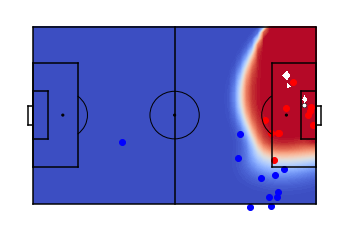

In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotsoccer import field
from IPython.core.display import HTML

xx = np.linspace(0,105,n_grid_points_x)
yy = np.linspace(0,68,n_grid_points_y)

locs_ball_reduced = locs_ball[first_frame:(first_frame + n_frames),:]
locs_home_reduced = locs_home[:,first_frame:(first_frame + n_frames),:]
locs_away_reduced = locs_away[:,first_frame:(first_frame + n_frames),:]

first_frame_to_plot = 38 * 60 * 25 + 2 * 25
n_frames_to_plot =  20 * 25

fig, ax=plt.subplots()
field(ax=ax,show = False)
ball_points = ax.scatter(locs_ball_reduced[first_frame_to_plot,0],locs_ball_reduced[first_frame_to_plot,1],color = 'black',zorder = 15, s = 16)
ball_points2 = ax.scatter(locs_ball_reduced[first_frame_to_plot,0],locs_ball_reduced[first_frame_to_plot,1],color = 'white',zorder = 15, s = 9)
home_points = ax.scatter(locs_home_reduced[:,first_frame_to_plot,0],locs_home_reduced[:,first_frame_to_plot,1],color = 'red',zorder = 10)
away_points = ax.scatter(locs_away_reduced[:,first_frame_to_plot,0],locs_away_reduced[:,first_frame_to_plot,1],color = 'blue',zorder = 10)
p = [ax.contourf(xx,
                 yy,
                 pitch_control[first_frame_to_plot].reshape(n_grid_points_y,n_grid_points_x).cpu(),
                 extent = (0,105,0,68),
                 levels = np.linspace(0,1,100),
                 cmap = 'coolwarm')]

def update(i):
    fr = i + first_frame_to_plot
    for tp in p[0].collections:
        tp.remove()
    p[0] = ax.contourf(xx,
                    yy,
                    pitch_control[fr].reshape(n_grid_points_y,n_grid_points_x).cpu(),
                    extent = (0,105,0,68),
                    levels = np.linspace(0,1,100),
                    cmap = 'coolwarm')
    ball_points.set_offsets(np.c_[[locs_ball[fr,0]],[locs_ball[fr,1]]])
    ball_points2.set_offsets(np.c_[[locs_ball[fr,0]],[locs_ball[fr,1]]])
    home_points.set_offsets(np.c_[locs_home[:,fr,0],locs_home[:,fr,1]])
    away_points.set_offsets(np.c_[locs_away[:,fr,0],locs_away[:,fr,1]])
    return p[0].collections + [ball_points,home_points,away_points]

ani = matplotlib.animation.FuncAnimation(fig, update, frames=n_frames_to_plot, interval=40, blit=True, repeat=False)

ani.save('pitch_control_animation.mp4', fps=25)